# The purposes of this notebook is to make a correct unique planetlist (and also a correct planetless star list)

The previous lists made were not correct; I simply used a list(set(LIST)) but this doesn't actually only yield unique items; it just only gives me onw copy of each star.  
This means that if, say, a star with TICID 123456 had 3 planets, there would be 3 entries for 123456 in planetList, and set(L) doesn't remove this from the list!

In [1]:
################################
# Scientific imports
################################
import gc
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from astropy.io import fits
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.stats import sigma_clipped_stats

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time, json, statistics
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange
from IPython.display import display

################################
# MatPlotLib Settings
################################
plt.rcParams["figure.figsize"] = (16,4)
sb.set()

# Skip to the end to the <code>np.load("True_NOO_Fluxes.npy")</code> section!

In [2]:
fitsList = np.load("fitslist.npy")

pl="tsop301_planet_data.txt"
sl="tsop301_star_data.txt"
ebl="tsop301_eb_data.txt"
bebl="tsop301_backeb_data.txt"

In [38]:
################################
# FUNCTIONS
################################

def DrawLC(N=-1):
    rndFile = random.randint(0,len(fitsList))
    #print("FILE IS {}".format(rndFile))
    #fileNum = fitsList[rndFile]
    fitsFile = fitsList[rndFile] if N==-1 else fitsList[N]

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        obj = hdulist[0].header['OBJECT']
        sector = hdulist[0].header['SECTOR']

        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds = hdulist[1].data['TIME']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], str(rndFile), str(obj), str(sector))

################################

def LoadListGeneral(f):
    lst=[]
    try:
        # Assuming everything CAN go well, do this
        with open('./SIM_DATA/unpacked/{}'.format(f)) as df:
            csvdf = csv.reader(df)
            for lineholder in csvdf:
                line = lineholder[0]                # I don't know why but this makes it work better
                if line[0]!="#":                    # Ignore commented lines (lines w/ FIRST STRING ELEMENT is a # character)
                    lst.append(line.split()[0])       # Add line to list
                # endif
            # endfor
        # endwith
    except FileNotFoundError:
        print("FNF")
        return
    # end try
    return lst

################################

def LoadList(itemtype="all"):
    
    foundflag=False
    
    # itemtype = (S)tar, (P)lanet, (E)clipsing (B)inary, or (B)ack (E)clipsing (B)inary
    if itemtype.lower() in ["s", "star", "all"]:
        foundflag = True
        starList = list(map(int,LoadListGeneral(sl)))
        print("Loading star list: {}".format(sl))
    if itemtype.lower() in ["p", "planet", "all"]:
        foundflag = True
        planetList = list(map(int,LoadListGeneral(pl)))
        print ("loading planet list: {}".format(pl))
    if itemtype.lower() in ["eb", "eclipsing binary", "eclipsingbinary", "all"]:
        foundflag = True
        ebList = list(map(int,LoadListGeneral(ebl)))
        print ("loading eb list: {}".format(ebl))
    if itemtype.lower() in ["beb", "back eclipsing binary", "backeclipsingbinary", "all"]:
        foundflag = True
        bebList = list(map(int,LoadListGeneral(bebl)))
        print ("loading beb list: {}".format(bebl))
        
    if foundflag:
        #global alllists
        alllists = {"s": starList, "p": planetList, "eb": ebList, "beb": bebList}
        return (alllists)
    else:
        # If an invalid selection has been entered
        print("You must enter either:\n"
               "* \"S\" (or \"Star\")\n"
               "* \"P\" (or \"Planet\")\n"
               "* \"EB\" (or \"Eclipsing Binary\")\n"
               "* \"BEB\" (or \"Back Eclipsing Binary\")")

################################

def IsThisAStar(n):
    return n in alllists["s"]
    
def IsThisAPlanet(n):
    return n in alllists["p"]

def IsThisAEB(n):
    return n in alllists["eb"]

def IsThisABEB(n):
    return n in alllists["beb"]

# Function to tell you what an item is
def WhatIsMyLC(n):
    lbl = []
    lbl.append("Star") if IsThisAStar(n) else lbl
    lbl.append("Planet") if IsThisAPlanet(n) else lbl
    lbl.append("EB") if IsThisAEB(n) else lbl
    lbl.append("BRB") if IsThisABEB(n) else lbl
    
    return "UNKNOWN" if lbl==[] else lbl

################################

def WhatIsItem(X):
    print("Our TIC code is {}!\n"
      "Is it A:\n"
     "* Planet? - {}\n"
     "* EB?     - {}\n"
     "* BEB?    - {}\n"
     "* Star?   - {}".format(X, (X in planetList), (X in ebList), (X in bebList), (X in starList)))

################################

def IsUnique(arr):
    
    uniqueItem = []
    
    for iterator in arr:
    
        # Check if count is 1; if it is, add to unique planet list
        if arr.count(iterator) == 1:
            uniqueItem.append(iterator)
    return uniqueItem

################################

def IsUniqueStar(sList, pList):
    
    uniqueStars = []
    c = 0

    for s in sList:
        if s not in pList:
            uniqueStars.append(s)
            c = c+1

    print(f"{c} ITEMS NOT IN PL; ARE PLANETLESS STARS")
    
    return uniqueStars

#################################

In [4]:
alllists = LoadList()
starList, planetList, ebList, bebList = alllists['s'], alllists['p'], alllists['eb'], alllists['beb']

Loading star list: tsop301_star_data.txt
loading planet list: tsop301_planet_data.txt
loading eb list: tsop301_eb_data.txt
loading beb list: tsop301_backeb_data.txt


In [5]:
TICList = [0]*len(fitsList)

isPlanetList = [0]*len(TICList)
isEbList = [0]*len(TICList)
isBebList = [0]*len(TICList)
isStarList = [0]*len(TICList)

# Make a list of EVERY TIC IN ORDER
for i in range(len(fitsList)):
    with fits.open(fitsList[i], mode="readonly") as hdulist:
        obj = hdulist[0].header['OBJECT']
        TICList[i] = int(obj.split('TIC ')[1])

# Time to do many loops

for i in range(len(TICList)):
    # The isPlanetList defaults to zero; check if TICList[i] is in plist
    OBJ = TICList[i]
    
    if OBJ in planetList:
        isPlanetList[i] = i
        # isPlanetList[i] = [OBJ, planetList.index(OBJ)]
        
    if OBJ in ebList:
        isEbList[i] = i
        # isEbList[i] = [OBJ, ebList.index(OBJ)]
        
    if OBJ in bebList:
        isBebList[i] = i
        # isBebList[i] = [OBJ, bebList.index(OBJ)]
        
    if OBJ in starList:
        isStarList[i] = i
        # isStarList[i] = [OBJ, starList.index(OBJ)]
        
isPlanetListShort = [i for i in isPlanetList if i != 0]
isEbListShort     = [i for i in isEbList     if i != 0]
isBebListShort    = [i for i in isBebList    if i != 0]
isStarListShort   = [i for i in isStarList   if i != 0]

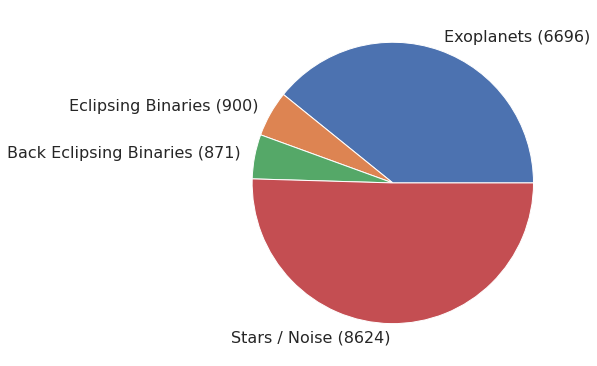

In [6]:
numP    = len(planetList)
numEB   = len(ebList)
numBEB  = len(bebList)
numSTAR = len(starList)
dataSpread = [numP, numEB, numBEB, numSTAR]

mylabels = ["Exoplanets ({})".format(numP),
            "Eclipsing Binaries ({})".format(numEB),
            "Back Eclipsing Binaries ({})".format(numBEB),
            "Stars / Noise ({})".format(numSTAR)] 
plt.rcParams["figure.figsize"] = (8,8)
plt.pie(dataSpread, labels=mylabels, textprops={'fontsize': 16}, startangle=0)
plt.rcParams["figure.figsize"] = (16,4)
#plt.show()
plt.tight_layout()
#plt.savefig('img/dataspread.png')

In [7]:
uniqueP    = IsUnique(planetList)
uniqueSTAR = IsUniqueStar(starList, planetList)

numP    = len(uniqueP)
numSTAR = len(uniqueSTAR)

numP, numSTAR, numP+numSTAR

6948 ITEMS NOT IN PL; ARE PLANETLESS STARS


(1115, 6948, 8063)

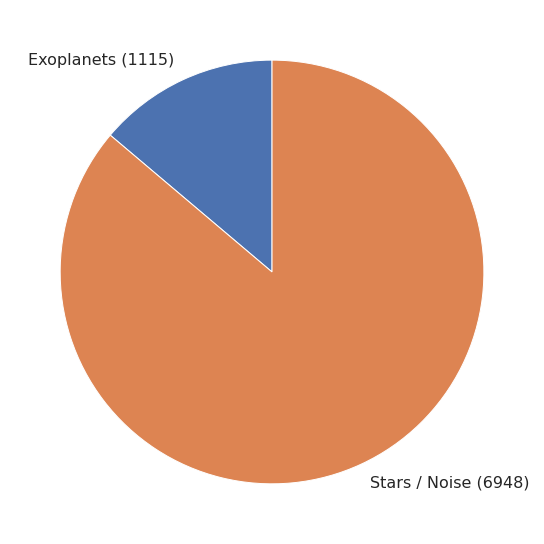

In [8]:
dataspread = [uniqueP, uniqueSTAR]
mylabelsnew = ["Exoplanets ({})".format(numP),
            "Stars / Noise ({})".format(numSTAR)] 
plt.rcParams["figure.figsize"] = (8,8)
plt.pie([numP, numSTAR], labels=mylabelsnew, textprops={'fontsize': 16}, startangle=90)

#plt.show()
plt.tight_layout()
plt.savefig('img/unique-exo-vs-stars.png')

In [9]:
NOOLIST = uniqueP + uniqueSTAR

In [10]:
def GetFilename(TICID,fitsList):
    
    for i in fitsList:
        if TICID in i:
            return i


In [11]:
NOO_FILES=[]

for i in NOOLIST:
    NOO_FILES.append(GetFilename(str(i),fitsList))

In [12]:
len(NOO_FILES)

8063

In [13]:
NOO_FILES[:25]

['SIM_DATA/tess2018191215100-s0001-0000000006400274-0001-a_lc.fits',
 'SIM_DATA/tess2018191215100-s0001-0000000006949210-0001-a_lc.fits',
 'SIM_DATA/tess2018191215100-s0001-0000000007088246-0001-a_lc.fits',
 'SIM_DATA/tess2018191215100-s0001-0000000061090239-0001-a_lc.fits',
 'SIM_DATA/tess2018191215100-s0001-0000000061135882-0001-a_lc.fits',
 'SIM_DATA/tess2018191215100-s0001-0000000061326006-0001-a_lc.fits',
 'SIM_DATA/tess2018191215100-s0001-0000000061458992-0001-a_lc.fits',
 'SIM_DATA/tess2018191215100-s0001-0000000061811090-0001-a_lc.fits',
 'SIM_DATA/tess2018191215100-s0001-0000000061897601-0001-a_lc.fits',
 'SIM_DATA/tess2018191215100-s0001-0000000062119727-0001-a_lc.fits',
 'SIM_DATA/tess2018191215100-s0001-0000000062124765-0001-a_lc.fits',
 'SIM_DATA/tess2018191215100-s0001-0000000062228498-0001-a_lc.fits',
 'SIM_DATA/tess2018191215100-s0001-0000000063684885-0001-a_lc.fits',
 'SIM_DATA/tess2018191215100-s0001-0000000091235807-0001-a_lc.fits',
 'SIM_DATA/tess2018191215100-s0001

In [14]:
isplanetlist = [0]*len(NOOLIST)
len(isplanetlist)

8063

In [15]:
for i in range(len(NOOLIST)):
    if NOOLIST[i] in planetList:
        isplanetlist[i] = 1

In [16]:
len(uniqueP)

1115

In [17]:
sum(isplanetlist)

1115

## v---------- Everything BELOW is related to saving the NOO files

In [31]:
np.save("True_NOO_isplanetlist.npy",isplanetlist)

In [ ]:
NOO_FILES[:10]
np.save("NOO_FILES.npy",NOO_FILES)

In [ ]:
NOO_FILES = np.load("NOO_FILES.npy")

In [ ]:
def GetFluxes(fitsFile):

    with fits.open(fitsFile, mode="readonly") as hdulist:
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    hdulist.close()
    return (pdcsap_fluxes[1:-1])

In [ ]:
# NOW TO RUN A TEST; IF WORKS, RUN ON SERVER

div = 1 + len(NOO_FILES)//2

# PART 1
#inArr = NOO_FILES[:div]

# PART 2
inArr = NOO_FILES[div:]

fluxArr = [None]*len(inArr)

In [ ]:
len(inArr), len(fluxArr)

In [ ]:
div = 1 + len(NOO_FILES) // 2
div, len(NOO_FILES[:div]), len(NOO_FILES[div:])

In [ ]:
for i in tqdm(range(len(inArr))):
    fluxArr[i] = GetFluxes(inArr[i])

In [ ]:
len(fluxArr)

In [ ]:
# PART 1
#np.save("NOO_PT1", fluxArr)

# PART 2
np.save("NOO_PT2", fluxArr)

In [ ]:
for i in tqdm(range(len(inArr[div:]))):
    fluxArr[div+i] = GetFluxes(inArr[div+i])

In [ ]:
N1 = np.load("NOO_PT1.npy")
N2 = np.load("NOO_PT2.npy")

In [ ]:
fullFluxArr = np.concatenate((N1,N2), axis=0)

In [ ]:
len(fullFluxArr)

In [ ]:
np.save("True_NOO_fluxes.npy",fullFluxArr)

In [18]:
fluxArr = np.load("True_NOO_fluxes.npy")

In [19]:
len(fluxArr)

8063

## ^---------- Everything ABOVE is related to saving the NOO files

In [19]:
def MakeNewList(numPics=5):
    lcArray = [0]*numPics #np.zeros((numPics,5))

    for ctr in range (numPics):
        # Set up random info if needed
        tstFile = random.choice(isPlanetListShort)
        #tstFile = TICARR[ctr]

        # Get the info
        x,y,f,o,_ = DrawLC(tstFile)

        # Standardise the Time Series (x co-ords)
        x[:] = [number - 1310 for number in x]

        # Normalise the Flux (y co-ords)
#        mean = np.median(y)
#        std=np.std(y)
#        y[:] = [(number/mean) for number in y]

        # Add to list
        lcArray[ctr] = [x,y,f,o]

    return lcArray

In [39]:
lcArray = MakeNewList()

File № 8008
TIC 129433074

File № 8583
TIC 350859059

File № 12708
TIC 382198673

File № 10790
TIC 257720377

File № 2116
TIC 129082347



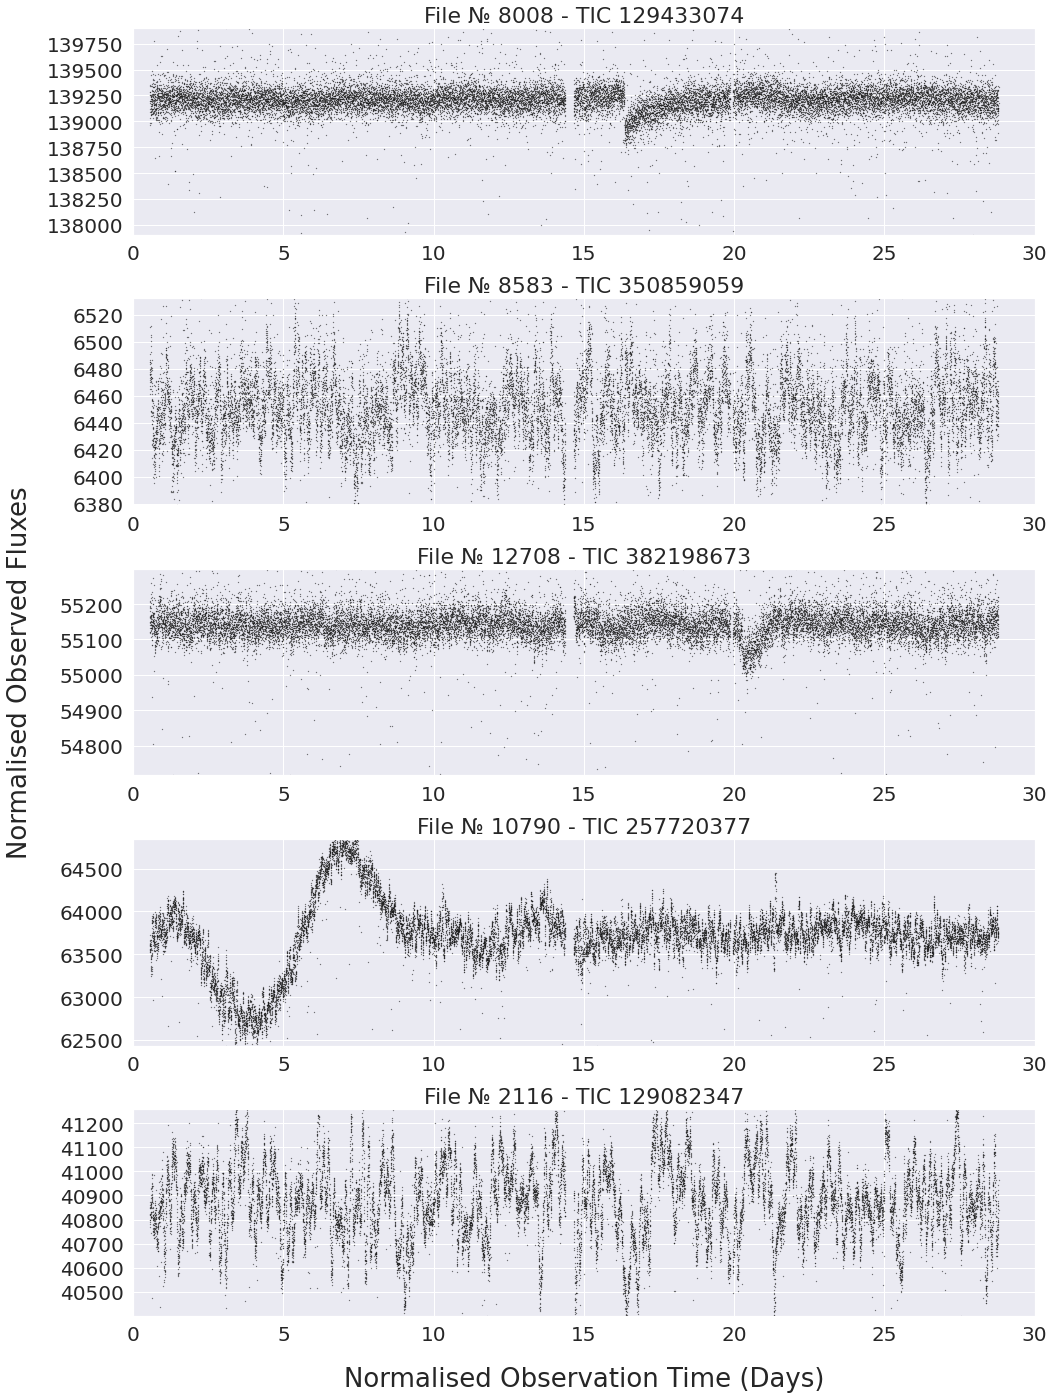

In [40]:
numplots = len(lcArray)

fig = plt.figure(figsize=(16,20))

for i in range(numplots):
    plt.subplot(numplots, 1, i+1)
    plt.plot(lcArray[i][0], lcArray[i][1], 'k.', markersize=0.5)
    
    LB = np.percentile(lcArray[i][1],1.5)
    UB = np.percentile(lcArray[i][1],99.5)
    
    plt.xlim([0,30])
    plt.ylim([LB,UB])
    
#    if i==1:
#        plt.ylim([1.01,0.99])
    
    fileID = lcArray[i][2]
    TICID  = lcArray[i][3]
    
    print(f"File № {fileID}")
    print(lcArray[i][3])
    print("")
    
    plt.title(f"File № {fileID} - {TICID}", fontsize=22)
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    #plt.xlabel("2nd and 99th percentile: {}, {}".format(LB,UB))


fig.add_subplot(111, frameon=False)

plt.xticks([])
plt.yticks([])

plt.ylabel("Normalised Observed Fluxes", fontsize=26, labelpad=100)
plt.xlabel("Normalised Observation Time (Days)", fontsize=26, labelpad=50)
plt.tight_layout()

#plt.savefig("img/exoplanetExmplesNEW_04.png")

plt.rcParams["figure.figsize"] = (16,4)

In [29]:
def MakePictures(inArr, numplots=5):
    fig = plt.figure(figsize=(16,20))

    for i in range(numplots):
        plt.subplot(numplots, 1, i+1)
        plt.plot(lcArray[i][0], lcArray[i][1], 'k.', markersize=0.5)

        LB = np.percentile(lcArray[i][1],1.5)
        UB = np.percentile(lcArray[i][1],99.5)

        plt.xlim([0,30])
        plt.ylim([LB,UB])

    #    if i==1:
    #        plt.ylim([1.01,0.99])

        fileID = lcArray[i][2]
        TICID  = lcArray[i][3]

        print(f"File № {fileID}")
        print(lcArray[i][3])
        print("")

        plt.title(f"File № {fileID} - {TICID}", fontsize=22)

        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        #plt.xlabel("2nd and 99th percentile: {}, {}".format(LB,UB))


    fig.add_subplot(111, frameon=False)

    plt.xticks([])
    plt.yticks([])

    plt.ylabel("Normalised Observed Fluxes", fontsize=26, labelpad=100)
    plt.xlabel("Normalised Observation Time (Days)", fontsize=26, labelpad=50)
    plt.tight_layout()

    #plt.savefig("img/exoplanetExmplesNEW_04.png")

    plt.rcParams["figure.figsize"] = (16,4)

In [34]:
X[0]

331743233

In [26]:
P, EB, BEB, S = GenerateLists(True)
sP = [int(x) for x in P]

In [28]:
UP = list(set(P).difference(EB))
X = list(set(sP) - set(BEB))

len(X), len(sP) - len(X), len(UP)

(1051, 64, 1115)

### So List "X" consists of ONLY exoplanets that ARE NOT also BEBs

In [ ]:
# f"TESS Object of Interest № {o[4:]} from the TESS Input Catalog", fontsize=20